# Twin-Delayed DDPG

## Installing the packages

In [3]:
!pip install pybullet

-------------------------------System Information---------------------------
Ip			20100 (192.168.88.1), interface:enp4s0
Uptime:			7 days
Kernel:			5.10.72-1-lts
Active User:		afshin afshin afshin afshin afshin

-------------------------------CPU/Memory Usage-----------------------------
Memory Usage: 44.92%     |    Swap Usage: 0.00%     |    CPU Usage: 18.65%

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 89.3 MB 225 kB/s eta 0:00:01


## Importing the libraries

3DT packages

In [2]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
# import pybullet_envs
# import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
# from gym import wrappers
from torch.autograd import Variable
from collections import deque

Others

In [1]:
# import community
import numpy as np
import networkx as nx
import matplotlib as mpl
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import graphviz
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import random
import pydoc

from decimal import Decimal
import json
import matplotlib.patches as mpatches

import sys
sys.path.append("..")
from src.utils import ColorPrint as _
# from src.ds import McmcTree as Tree
from datasets.synthetic.generator import TreeGenerator

In [18]:
# import community


class Tree(): #McmcTree
    def __set_plt(self):
        font = {
            'weight' : 'normal',
            'size'   : 8
        }
        mpl.rc('font', **font)
        

    def __init__(self, nodes, D, data_list=None, alpha=0.001, beta=0.1, root='DNM3', name='My Tree', logfile=None):
        self.__T = nx.DiGraph()
        
        if data_list:
            NWD = list( (n, dict(data=d)) for n, d in zip(nodes, data_list) )
            self.__T.add_nodes_from(NWD)
            self.num_cells = len(data_list[0])
            self.num_genes = len(nodes)
        else:
            self.__T.add_nodes_from(nodes)
        self.__best_T = self.__T.copy()
        self.alpha = alpha
        self.beta = beta
        self.root = root
        self.gene_names = nodes
        self.name = name
        self.__rho = 6
        self.D = D
        self.step = 0
        self.logfile = logfile

        self.last_A_hash = None
        self.last_A = None
        self.last_E_hash = None
        self.last_E = None

        self.gt_D = None
        self.gt_E = None
        self.gt_T = None

        self.__random_errors = []
        self.__best_errors = []
        self.__errors = []
        
        self.run_data = []
    
#         _.print_info('\nNew mcmc tree named:', name)

    
    def set_rho(self, rho):
        self.__rho = rho
    
    def set_ground_truth(self, gt_D, gt_E, gt_T=None):
        self.gt_D = gt_D
        self.gt_E = gt_E
        if gt_T:
            self.gt_T = gt_T
        return

    def plot_gt_T(self, title='truth tree'):
        pdot = nx.drawing.nx_pydot.to_pydot(self.gt_T)
        pdot.write_png('example.png')
        img = mpimg.imread('example.png')
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
            

    def __plot_matrix(self, M, title, cmap=None, labels=None, xlabel='cells', ylabel='genes', xticks=None, yticks=None, filename=None):
        t = 1 ## alpha value
        if not cmap:
            cmap = {0:[1,1,0.95,t], 1:[0.5,0.5,0.8,t], -1:[0.8,0.5,0.5,t]}
        if not labels:
            labels = {0:'0', 1:'1', -1:'-1'}
        arrayShow = np.array([[cmap[i] for i in j] for j in M])    
        ## create patches as legend
        patches =[mpatches.Patch(color=cmap[i],label=labels[i]) for i in cmap]
        plt.imshow(arrayShow, interpolation="nearest")
        plt.legend(handles=patches, loc=2, borderaxespad=-6)

        m, n = M.shape
        plt.yticks(range(m), [i for i in self.gene_names] if not yticks else yticks)
        plt.xticks(range(n), ['cell %d'%i for i in range(n)] if not xticks else xticks)
        plt.xticks(rotation=60)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if title:
            plt.title(title)
        if filename:
            plt.savefig(filename)
            plt.close()
        else:
            return plt

    def __plot_E(self, E, title, filename=None):
        self.__plot_matrix(E, title, filename=filename)

    def __plot_D(self, D, title, filename=None):
        labels = {0:'0', 1:'1', 3:'missed'}
        cmap = {0:[1,1,0.95,1], 1:[0.5,0.5,0.8,1], 3:[0.75,0.75,0.875,0.5]}
        self.__plot_matrix(D, title, filename=filename, labels=labels, cmap=cmap)

    def __plot_DmE(self, DmE, title, filename=None):
        labels = {0:'true', 1:r'false positive (\alpha)', -1:r'false negetive (\beta)', 2:'accepted (1)', 3:'accepted (0)'}
        cmap = {0:[1,1,0.95,1], 1:[0.5,0.5,0.8,1], -1:[0.8,0.5,0.5,1], 2:[0.5,0.5,1,0.25], 3:[1,0.5,0.5,0.25]}
        self.__plot_matrix(DmE, title, filename=filename, labels=labels, cmap=cmap)
    
    def __plot_EmGtE(self, DmE, title, filename=None):
        labels = {0:'true', 1:r'false positive (\alpha)', -1:r'false negetive (\beta)'}
        self.__plot_matrix(DmE, title, filename=filename, labels=labels)

    def __plot_DmGtE(self, DmE, title, filename=None):
        labels = {0:'true', 1:r'false positive (\alpha)', -1:r'false negetive (\beta)', 2:'accepted (1)', 3:'accepted (0)'}
        cmap = {0:[1,1,0.95,1], 1:[0.5,0.5,0.8,1], -1:[0.8,0.5,0.5,1], 2:[0.5,0.5,1,0.25], 3:[1,0.5,0.5,0.25]}
        self.__plot_matrix(DmE, title, filename=filename, labels=labels, cmap=cmap)

    def __plot_A(self, A, title, filename=None):
        xlabel = 'Attached cells to every node(gene) in the Mutation Tree'
        xticks = ['cell %s'%i for i in self.gene_names]
        self.__plot_matrix(A, title, filename=filename, xlabel=xlabel, xticks=xticks)

    def __plot_charts(self, filename=None):
        plt.plot(self.__errors, 'r', label='Accepted Error') # accepted errors
        plt.plot(self.__random_errors, 'k', label='Random Error') # random errors
        # plt.plot(self.enrgs) # best errors
        plt.legend()
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Changing loss after {} step'.format(self.step))
        if filename:
            plt.savefig(filename)
        # plt.show()
        return
    
    def __plot_pm_charts(self, filename=None, p=5):
        new_acc_errors = []
        new_random_errors = []
        for i, t in enumerate(np.array(self.run_data)):
            rnd = np.random.rand()
            if t[-1] > rnd/2:
                new_acc_errors.append(self.__errors[i])
                new_random_errors.append(t[-2])
                
        plt.plot(new_acc_errors[1:], 'r', label='Accepted Error') # accepted errors
        plt.plot(new_random_errors, 'k', label='Random Error') # random errors
        # plt.plot(self.enrgs) # best errors
        plt.legend()
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Changing loss after {} step'.format(len(new_random_errors)))
        if filename:
            plt.savefig(filename+"_pm")
        # plt.show()
        return
    
    def plot_eng_chart(self):
        self.__plot_pm_charts()

    def save_mats(self, prefix_dir=None):
        D = self.__get_D()
        A = self.__get_A()
        E = self.__get_E()
        best_T = self.get_best_tree()
        gt_D = self.gt_D
        gt_E = self.gt_E
        gt_T = self.gt_T
        np.savetxt('{}D_n{}_m{}_a{}_b{}.mat'.format(prefix_dir, self.num_cells, self.num_genes, self.alpha, self.beta), D)
        np.savetxt('{}A_n{}_m{}_a{}_b{}.mat'.format(prefix_dir, self.num_cells, self.num_genes, self.alpha, self.beta), A)
        np.savetxt('{}E_n{}_m{}_a{}_b{}.mat'.format(prefix_dir, self.num_cells, self.num_genes, self.alpha, self.beta), E)
        np.savetxt('{}gtD_n{}_m{}_a{}_b{}.mat'.format(prefix_dir, self.num_cells, self.num_genes, self.alpha, self.beta), gt_D)
        np.savetxt('{}gtE_n{}_m{}_a{}_b{}.mat'.format(prefix_dir, self.num_cells, self.num_genes, self.alpha, self.beta), gt_E)


    def plot_all_results(self, plot_pm=False, p=5):
        D = self.__get_D()
        A = self.__get_A()
        E = self.__get_E()
        best_T = self.get_best_tree()
        gt_D = self.gt_D
        gt_E = self.gt_E
        gt_T = self.gt_T
        
        self.__set_plt()
        if gt_D is not None and gt_E is not None:
            
            plt.figure(figsize=(30, 50))

            plt.subplot2grid((8, 2), (0, 0), rowspan=3)
            pdot = nx.drawing.nx_pydot.to_pydot(best_T)
            pdot.write_png('example.png')
            img = mpimg.imread('example.png')
            # plt.figure(figsize=(30,40))
            plt.imshow(img)
            plt.title('best tree with error:{:0.3f}'.format(self.get_best_error()/10))
            plt.axis('off')

            plt.subplot2grid((8, 2), (0, 1), rowspan=3)
            pdot = nx.drawing.nx_pydot.to_pydot(gt_T)
            pdot.write_png('example.png')
            img = mpimg.imread('example.png')
            # plt.figure(figsize=(40,40))
            plt.imshow(img)
            plt.title('truth tree')
            plt.axis('off')

            plt.subplot2grid((8, 3), (3, 0))
            self.__plot_D(D, 'D')
            plt.subplot2grid((8, 3), (3, 1))
            self.__plot_D(gt_D, 'Ground Truth D (GT_D)')
            plt.subplot2grid((8, 3), (3, 2))
            self.__plot_DmE(D - gt_D, 'D - GT_D')

            plt.subplot2grid((8, 3), (4, 0))
            self.__plot_E(E, 'E')
            plt.subplot2grid((8, 3), (4, 1))
            self.__plot_E(gt_E, 'Ground Truth E (GT_E)')
            plt.subplot2grid((8, 3), (4, 2))
            self.__plot_EmGtE(E - gt_E, 'E - GT_E')


            plt.subplot2grid((8, 3), (5, 0))
            self.__plot_DmE(D-E, 'D - E')
            plt.subplot2grid((8, 3), (5, 1))
            self.__plot_EmGtE(gt_D-gt_E, 'GT_D - GT_E')
            plt.subplot2grid((8, 3), (5, 2))
            self.__plot_DmE(D - gt_E, 'D - GT_E')

            plt.subplot2grid((8, 3), (6, 0), colspan=3)
            if plot_pm:
                self.__plot_pm_charts(p=p)
            else:
                self.__plot_charts()
        else:
            plt.figure(figsize=(20, 20))
            plt.subplot(211)
            self.__plot_charts()
            plt.subplot(245)
            self.__plot_D(D, 'D')
            plt.subplot(246)
            self.__plot_E(E, 'E')
            plt.subplot(247)
            self.__plot_DmE(D-E, 'D-E')
            plt.subplot(248)
            self.__plot_A(A, 'A')
            plt.title('Sharing x per column, y per row')
        plt.savefig('benchmark')
        plt.close()

    def __data(self, n):
        if Decimal(nx.__version__) < 2.4:
            return self.__T.node[n]['data']
        else:
            return self.__T.nodes[n]['data']
            
    def parent(self, n):
        return list(self.__T.predecessors(n))[0]
    
    def __swap_nodes(self,):
        n1, n2, p1, p2 = '', '', '', ''
        T = self.__T.copy()
        while True:
            n1 = random.choice(list(T.nodes))
            n2 = random.choice(list(T.nodes))

            if not n1 == n2:
                if n1 != self.root and n2 != self.root:
                    break
        p1 , p2 = self.parent(n1), self.parent(n2)
        n1_childs = list(T.neighbors(n1))
        n2_childs = list(T.neighbors(n2))

        T.remove_edge(p1, n1)
        T.remove_edge(p2, n2)

        if p1 == n2 :
            T.add_edge(p2, n1)
            T.add_edge(n1, n2)
            # _.print_info('n1:{}, n2_childs:{}, n2:{}'.format(n1, n2_childs, n2))
        elif p2 == n1 :
            T.add_edge(p1, n2)
            T.add_edge(n2, n1)
            # _.print_info('n2:{}, n1_childs:{}, n1:{}'.format(n2, n1_childs, n1))
        else:
            T.add_edge(p1, n2)
            T.add_edge(p2, n1)

        for n1_child in n1_childs:
            if not n1_child == n2:
                T.remove_edge(n1, n1_child)
                T.add_edge(n2, n1_child)

        for n2_child in n2_childs:
            if not n2_child == n1:
                T.remove_edge(n2, n2_child)
                T.add_edge(n1, n2_child)

        self.__finilizing_step(T, 'swap_nodes')

    def __swap_subtrees(self,):
        n1, p1 , n2, p2 = '', '', '', ''
        PTN = []
        while True:
            T = self.__T.copy()
            n1 = random.choice(list(T.nodes))
            if not n1 == self.root:
                p1 = self.parent(n1)
                if not p1 == self.root:
                    T.remove_edge(p1, n1)
                    WCC = list(list(wc) for wc in nx.algorithms.components.weakly_connected_components(T))
                    PTN = WCC[0] if p1 in WCC[0] else WCC[-1]
                    if len(PTN) > 2:
                        break
        while True:
            n2 = random.choice(PTN)
            if not n2 == self.root and not n2 == p1:
                break
        p2 = self.parent(n2)
        # T = self.__T.copy()
        # T.remove_edge(p1, n1)      
        T.remove_edge(p2, n2)

        T.add_edge(p2, n1)
        if n2 in list(nx.algorithms.ancestors(self.__T, p1)):
            T.add_edge(n1, n2)
        else:
            T.add_edge(p1, n2)            
        self.__finilizing_step(T, 'swap_subtrees')

    def __prune_reattach(self,):
        T = self.__T.copy()
        n1, p , n2 = '', '', ''
        while True:
            n1 = random.choice(list(T.nodes))
            if not n1 == self.root:
                p = self.parent(n1)
                break    
        T.remove_edge(p, n1)
        WCC = list(list(wc) for wc in nx.algorithms.components.weakly_connected_components(T))
        PTN = WCC[0] if p in WCC[0] else WCC[-1]
        n2 = random.choice(PTN)
        T.add_edge(n2, n1)
        
        # print(n1, n2, )
        self.__finilizing_step(T.copy(), 'prune_reattach')
        
    def __finilizing_step(self, new_T, method):
        # _.print_warn(hash(new_T))
        new_error = self.__calc_tree_error(new_T)
        if new_error > 0:
            acc_prob = min(1, (self.__errors[-1]/new_error))
        else:
            acc_prob = 1

        if method == 'swap_nodes':
            if acc_prob<1: acc_prob = acc_prob**10
        else:
            if acc_prob<1: acc_prob = acc_prob**self.__rho

        self.__random_errors.append(new_error)
        
        if np.random.rand() <= acc_prob:
            self.__T = new_T.copy()
            self.__errors.append(new_error)
        else:
            self.__errors.append(self.__errors[-1])
    
        if new_error < self.__best_errors[-1]:
            self.__best_errors.append(new_error)
            self.__best_T = new_T.copy()
        else:
            self.__best_errors.append(self.__best_errors[-1])
        
        self.run_data.append(
            [self.step, new_error, acc_prob]
        )
        
        if self.step % 10000 == 0:
            print(
                ',\t'.join([
                    'step:{:3d}'.format(self.step),
                    'mode:{}'.format(method),
                    'new_error:{:.2f}'.format(new_error),
                    'last_error:{:.2f}'.format(self.__errors[-1]),
                    'acc_prob:{:0.3f}'.format(acc_prob),
                ])
            )
        if self.logfile:
            self.logfile.write(
                ',\t'.join([
                'step:{:3d}'.format(self.step),
                'mode:{}'.format(method),
                'new_error:{:.2f}'.format(new_error),
                'last_error:{:.2f}'.format(self.__errors[-1]),
                'acc_prob:{:0.3f}\n'.format(acc_prob),
                ])
            )

       
    def get_tree(self,):
        return self.__T.copy()

    def get_best_tree(self,):
        return self.__best_T.copy()

    def get_best_error(self):
        return self.__best_errors[-1]

    def get_errors(self):
        return self.__errors


    def __initialize_params(self):
        self.step = 0
        error = self.__calc_tree_error()
        self.__errors = [error]
        self.__random_errors = [error]
        self.__best_errors = [error]
        self.__best_T = self.__T.copy()
 
    def set_edges(self, edges, remove_edges=False):
        if remove_edges:
            self.__T.remove_edges_from(list(self.__T.edges))
        self.__T.add_edges_from(edges)
        self.__initialize_params()
     
    def randomize(self,):
        self.__errors = []
        self.__random_errors = []
        self.__best_errors = []
        self.__T.remove_edges_from(list(self.__T.edges))
        nodes = list(self.__T.nodes())
        np.random.shuffle(nodes)
        nodes.remove(self.root)
        nodes.append(self.root)
        for i, n in enumerate(nodes[:-1]):
            p = random.choice(nodes[i+1:])
            self.__T.add_edge(p, n)
        self.__initialize_params()
       
    
    def plot_probs(self):
        plt.figure(figsize=(30,10))
        plt.hist(self.probs)
        plt.title('after {} step'.format(self.step))
        # plt.show()
        return
    
    def plot_best_T(self, filename=None):
        T = self.__best_T
        
        # p = nx.drawing.nx_pydot.to_pydot(T)
        # p.write_png('example.png')
        # img = mpimg.imread('example.png')
        # plt.figure(figsize=(20,20))
        # plt.imshow(img)
        # plt.title('best tree with error:{}'.format(self.get_best_error()))
        # plt.axis('off')

        # tree with attached cells...
        D = self.__get_D()
        A = self.__get_A(T)

        attachments = dict((g, []) for g in self.gene_names)

        for j in range(D.shape[1]):
            d = D[:,j]
            probs = []
            for e in A.T:
                prob = self.__calc_sample_distance(e, d)
                probs.append(prob)
            max_idx = np.argmax(probs)
            attachments[self.gene_names[max_idx]].append('{}|{:0.1f}'.format(j, probs[max_idx]))
        
        attached_T = T.copy()
        for gene, samples in attachments.items():
            for s in samples:
                attached_T.add_edge(gene, s)

        pdot = nx.drawing.nx_pydot.to_pydot(attached_T)
        for i, node in enumerate(pdot.get_nodes()):
            node_name = str(node)[:-1]
            print(node_name)
            if '|' in node_name:
                # node.set_label('s%s'%node_name.split()[-1][:-1])
                node.set_shape('egg')
                # node.set_fillcolor('#db8625')
                node.set_color('red')

        pdot.write_png('example.png')
        img = mpimg.imread('example.png')
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        plt.title('best tree with error:{:0.3f}'.format(self.get_best_error()/10))
        plt.axis('off')

        if filename:
            plt.savefig(filename)
            edges = tuple(T.edges())
            with open(filename+'.edges', 'w') as f:
                f.write('['+','.join(['({}, {})'.format(u, v) for u, v in edges])+']')
        # plt.show()
        return


    def __get_D(self):
        return self.D
        # if self.D:
        #     return D
        # else:
        #     genes = self.__best_T.nodes(data=True)
        #     D = np.zeros([self.num_genes, self.num_cells], dtype=np.int)
        #     for i, g in enumerate(genes):
        #         D[i, :] = np.array(g[1]['data'])
        #     return D

    def __get_A(self, T=None):
        if not T:
            T = self.__T.copy()
        if hash(tuple(T.edges)) == self.last_A_hash:
            return self.last_A
        A = np.eye(self.num_genes)
        for j, gene_name in enumerate(self.gene_names):
            ancestors = nx.algorithms.ancestors(T, gene_name)
            for i in range(len(self.gene_names)):
                if self.gene_names[i] in ancestors:
                    A[i, j] = 1
        self.last_A_edges = hash(tuple(T.edges))
        self.last_A = A
        return A

    def __calc_sample_distance(self, from_sample, to_sample):
        ''' FromSamle(E) ~> ToSample(D) '''
        prob = 0
        a, b = self.alpha, self.beta
        for f,t in zip(from_sample, to_sample):
            if int(t) == 3: continue # missed data
            p = f*t*(1-b) + (1-f)*(1-t)*(1-a) + f*(1-t)*b + (1-f)*t*a
            prob += np.log(p)
        return prob

    def __get_E(self, T=None):
        if not T:
            T = self.__T.copy()
        if hash(tuple(T.edges)) == self.last_E_hash:
            return self.last_E
        D = self.__get_D()
        A = self.__get_A(T=T)
        E = np.zeros_like(D)
        for j in range(D.shape[1]):
            d = D[:,j]
            probs = []
            for e in A.T:
                prob = self.__calc_sample_distance(e, d)
                probs.append(prob)
            max_idx = np.argmax(probs)
            E[:,j] = A[:, max_idx]
            # print(probs[max_idx])
        self.last_E_hash = hash(tuple(T.edges))
        self.last_E = E
        return E

    def __calc_tree_error(self, T=None):
        D = self.__get_D()
        E = self.__get_E(T=T)
        
        DPE = D+E
        DME = D-E
        
        tn_cnt = self.num_cells*self.num_genes - np.count_nonzero(DPE)
        tp_cnt = self.num_cells*self.num_genes - np.count_nonzero(DPE-2)
        
        fn_cnt = self.num_cells*self.num_genes - np.count_nonzero(DME+1)
        fp_cnt = self.num_cells*self.num_genes - np.count_nonzero(DME-1)

#         DmE = D-E
#         DmE[np.where(np.abs(DmE) > 1)] = 0
#         D_and_E = D*E
#         D_and_E[np.where(np.abs(D_and_E) > 1)] = 1

#         ze_cnt = np.ones(self.num_cells)*self.num_genes - np.count_nonzero(DmE, 0)
#         tp_cnt = np.count_nonzero(D_and_E-1, 0)
#         tn_cnt = ze_cnt - tp_cnt
#         fp_cnt = np.count_nonzero(DmE-1, 0) - ze_cnt
#         fn_cnt = np.count_nonzero(DmE+1, 0) - ze_cnt
        ep = 0
        prob =  np.log((1-self.beta )**tp_cnt + ep) +\
                np.log((1-self.alpha)**tn_cnt + ep) +\
                np.log(self.beta **fn_cnt + ep) +\
                np.log(self.alpha**fp_cnt + ep)

#         error = np.sum(self.beta*fn_cnt + self.alpha*fp_cnt)*10
        # error = np.abs(np.linalg.norm(E) - np.linalg.norm(D))
        # error = np.sum(np.abs( (DmE**1)[:] ) )

        # _.print_info('Error:', error)
        error = -1*prob
        return error**1.5
    
    base_step = 8
    face_step = 8
    def next(self,):
        if not self.__best_errors[-1]:
            return True
        self.step += 1
        if self.step % (self.base_step+self.face_step) < self.base_step:
            rnd = np.random.rand()
            if rnd < 0.5:
                self.__prune_reattach()
            else:
                self.__swap_subtrees()
        else:
            self.__swap_nodes()  
        return False
            


#         pos = graphviz_layout(T, prog='twopi', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
#         plt.figure(figsize=(20,20))
#         nx.draw_networkx_nodes(T, pos, T.nodes, node_size=9000, alpha=0.5, 
#                                node_color="k", font_size=34, font_weight='bold')
#         nx.draw_networkx_labels(T, pos, font_size=14, font_weight='bold', font_color='w')
#         nx.draw_networkx_edges(T, pos, edge_color='gray', alpha=0.925, width=1)
#         plt.axis('equal')
#         plt.axis('off')
#         plt.show()

## Global Variables

In [19]:
M = 10
N = 15
ZETA = 1
Gamma = 0.15
alpha = 0.002
beta = 0.03
MR = 0.02

tg = TreeGenerator(
    M = M,
    N = N,
    ZETA = ZETA,
    Gamma = Gamma,
    alpha = alpha,
    beta = beta,
    MR = MR,
)
(gt_E, gt_D, D, gt_T) = tg.generate()
gensNames = list( str(i) for i in range(M) )
print(gensNames)



C_num = D.shape[1]
G_num = D.shape[0]
_.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )



### fill missed data
def tf(m,c):
    os = len(np.where(D[:,c]==1.))*1.
    zs = len(np.where(D[:,c]==0.))*1.
    return 1. if np.random.rand() < os/(os+zs) else 0.

for m in range(G_num):
    for c in range(C_num):
        if D[m,c] == 3.:
            D[m,c] = tf(m,c)


### Run
dl = list(d for d in D)
root = [n for n,d in gt_T.in_degree() if d==0][0]
print('ROOT:', root)
T = Tree(gensNames, D, data_list=dl, root=str(root), alpha=alpha, beta=beta)
T.set_ground_truth(gt_D, gt_E, gt_T=gt_T)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ROOT: 5


There is 15 cells and 10 mutations at 10 genes in this dataset.


0 [data="[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]"]
1 [data="[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"]
2 [data="[0 0 0 1 0 1 1 0 0 1 0 0 1 0 1]"]
3 [data="[0 1 0 1 0 1 1 0 0 1 0 0 1 1 0]"]
4 [data="[1 1 1 1 1 1 1 1 1 1 0 0 1 1 1]"]
5 [data="[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]"]
6 [data="[1 0 1 1 1 1 1 0 0 1 0 0 1 1 1]"]
7 [data="[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]"]
8 [data="[0 1 1 1 0 1 1 0 0 1 0 0 0 0 0]"]
9 [data="[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]"]
"1|-12.5"
"0|-3.6"
"2|-9.8"
"3|-22.2"
"4|-3.6"
"5|-25.0"
"6|-22.2"
"9|-22.2"
"12|-25.0"
"13|-9.8"
"14|-9.8"
"7|-6.3"
"8|-6.3"
"10|-0.0"
"11|-0.0"


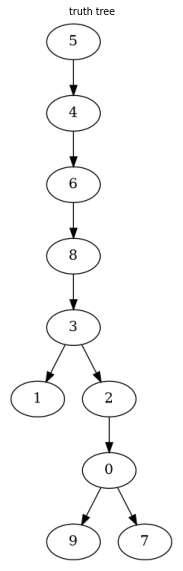

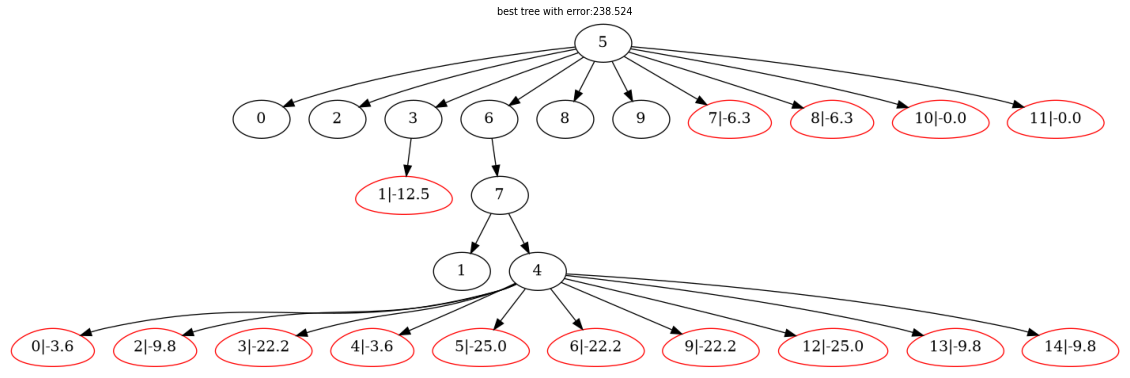

In [21]:
T.randomize()
T.plot_gt_T()
T.plot_best_T('initial T')


T.set_rho(10)

for i in range(1000):
    if T.next():
        break


T.plot_all_results()

In [ ]:
# shape[0] -> dimension



class GYM(object):
    def __init__(self):
        pass
    
    def make_env(self, name):
        M = 10
        N = 15
        ZETA = 1
        Gamma = 0.15
        alpha = 0.002
        beta = 0.03
        MR = 0.02

        env = Environment(M=M, N=N, ZETA=ZETA, Gamma=Gamma, alpha=alpha, beta=beta, MR=MR)
        return env
    

class ActionSpace(object):
    def __init__(self):
        self.high = []
        self.low = []
        self.shape = []
    
    def sample(self):
        pass
    

class ObservationSpace(object):
    def __init__(self):
        self.high = []
        self.low = []
        self.shape = []
    
    
class Environment(M=10, N=15, ZETA=1, Gamma=0.15, alpha=0.002, beta=0.03, MR=0.02):
    def __init__(self):
        sefl.observation_space = ObservationSpace()
        self.action_space = ActionSpace()
        self._max_episode_steps = 1000
        self.M     = M
        self.N     = N
        self.ZETA  = ZETA
        self.Gamma = Gamma
        self.alpha = alpha
        self.beta  = beta
        self.MR    = MR
        self.T     = T
        
        
        tg = TreeGenerator(
            M = M,
            N = N,
            ZETA = ZETA,
            Gamma = Gamma,
            alpha = alpha,
            beta = beta,
            MR = MR,
        )
        (gt_E, gt_D, D, gt_T) = tg.generate()
    
        gensNames = list( str(i) for i in range(M) )
        print(gensNames)



C_num = D.shape[1]
G_num = D.shape[0]
_.print_warn( 'There is {} cells and {} mutations at {} genes in this dataset.'.format(C_num, G_num, len(gensNames)) )

        
        
    
    def __get_score_T(self, T):
        pass
    
    def reset(self):
        pass
    
    def __genInput(self.D, self.X, self.alpha, self.beta):
        pass
    
    def self.__choose_nodes(Pr, At):
        ''' choose a node to proune and a node to reattach'''
        pr_node = np.random.choice(a=range(len(Pr)),size=1,p=Pr)
        remain_T = sub_tree(T, pr_node)
        
        at_node = 
        return pr_node, at_node
    
    def step(self, action):
        Pr, At = action[:self.M], action[self.M:]
        pr_node, at_node = self.__choose_nodes(Pr, At)
        
        reward = self.score_T - self.score_new_T
        
        obs = self.__genInput(self.D, self.X, self.alpha, self.beta)
        return obs, reward, done, _
    
    def action_sample():
        pass
    
    def seed(self, seed):
        pass

## Step 1: We initialize the Experience Replay memory

In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind: 
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

## Step 2: We build one neural network for the Actor model and one neural network for the Actor target

In [0]:
class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_action * torch.tanh(self.layer_3(x))
    return x

## Step 3: We build two neural networks for the two Critic models and two neural networks for the two Critic targets

In [0]:
class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

## Steps 4 to 15: Training Process

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [0]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## We set the parameters

In [0]:
env_name = "AntBulletEnv-v0" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
expl_noise = 0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 0.5 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## We create a file name for the two saved models: the Actor and Critic models

In [0]:
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

## We create a folder inside which will be saved the trained models

In [0]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

## We create the PyBullet environment

In [0]:
env = gym.make(env_name)

## We set seeds and we get the necessary information on the states and actions in the chosen environment

In [0]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

## We create the policy network (the Actor model)

In [0]:
policy = TD3(state_dim, action_dim, max_action)

## We create the Experience Replay memory

In [0]:
replay_buffer = ReplayBuffer()

## We define a list where all the evaluation results over 10 episodes are stored

In [0]:
evaluations = [evaluate_policy(policy)]

## We create a new folder directory in which the final results (videos of the agent) will be populated

In [0]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path
work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env._max_episode_steps
save_env_vid = False
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()

## We initialize the variables

In [0]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

In [0]:
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:

    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    
    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
  
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.action_space.sample()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(np.array(obs))
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done, _ = env.step(action)
  
  # We check if the episode is done
  done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
  
  # We increase the total reward
  episode_reward += reward
  
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs, new_obs, action, reward, done_bool))

  # We update the state, the episode timestep, the total timesteps, and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

## Inference

In [0]:
class Actor(nn.Module):
  
  def __init__(self, state_dim, action_dim, max_action):
    super(Actor, self).__init__()
    self.layer_1 = nn.Linear(state_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, action_dim)
    self.max_action = max_action

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_action * torch.tanh(self.layer_3(x)) 
    return x

class Critic(nn.Module):
  
  def __init__(self, state_dim, action_dim):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim + action_dim, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Defining the second Critic neural network
    self.layer_4 = nn.Linear(state_dim + action_dim, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u):
    xu = torch.cat([x, u], 1)
    # Forward-Propagation on the first Critic Neural Network
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    # Forward-Propagation on the second Critic Neural Network
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    x2 = self.layer_6(x2)
    return x1, x2

  def Q1(self, x, u):
    xu = torch.cat([x, u], 1)
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    x1 = self.layer_3(x1)
    return x1

# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building the whole Training Process into a class

class TD3(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.actor = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    self.max_action = max_action

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # Step 4: We sample a batch of transitions (s, s’, a, r) from the memory
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # Step 5: From the next state s’, the Actor target plays the next action a’
      next_action = self.actor_target(next_state)
      
      # Step 6: We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)
      
      # Step 7: The two Critic targets take each the couple (s’, a’) as input and return two Q-values Qt1(s’,a’) and Qt2(s’,a’) as outputs
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      
      # Step 8: We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # Step 9: We get the final target of the two Critic models, which is: Qt = r + γ * min(Qt1, Qt2), where γ is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # Step 10: The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state, action)
      
      # Step 11: We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # Step 12: We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Step 13: Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Step 14: Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Step 15: Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    while not done:
      action = policy.select_action(np.array(obs))
      obs, reward, done, _ = env.step(action)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

env_name = "AntBulletEnv-v0"
seed = 0

file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

eval_episodes = 10
save_env_vid = True
env = gym.make(env_name)
max_episode_steps = env._max_episode_steps
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
policy.load(file_name, './pytorch_models/')
_ = evaluate_policy(policy, eval_episodes=eval_episodes)